In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import shap
from shap.plots import bar
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

In [2]:
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
filter_lines = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], Line2D), zip(handles, labels)))
filter_paths = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], PathCollection), zip(handles, labels)))

In [3]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

# Generate Explanations

In [5]:
%%time

indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='indiv', space_type='log_odds')
with open('explanations/indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
    
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 247it [03:21,  1.18it/s]                         
Exact explainer: 247it [06:32,  1.64s/it]                         

CPU times: user 11min 49s, sys: 1min 57s, total: 13min 46s
Wall time: 9min 53s


In [9]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'explanations/clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)
CPU times: user 22min 10s, sys: 10 s, total: 22min 20s
Wall time: 23min 7s


In [5]:
with open('explanations/diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)
with open('explanations/indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)
with open(f'explanations/clustering.pickle', 'rb') as f:
    state = pickle.load(f)
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values, focus_class=None,
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions, state=state)

# Individual Explanations

In [6]:
node.focus_class = None

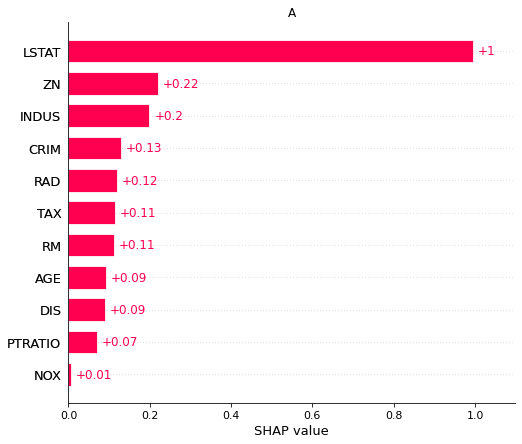

In [7]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['A.0', 'A.1', 'A.2']])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
with open('../explanations/featimp-a.pickle', 'wb') as f:
    pickle.dump(feature_importance.values, f)

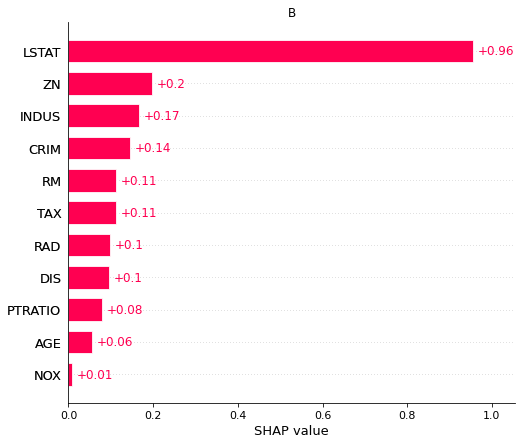

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['B.0', 'B.1', 'B.2']])
plot_feature_importance_bar(feature_importance, 'B', feature_order)
with open('../explanations/featimp-b.pickle', 'wb') as f:
    pickle.dump(feature_importance.values, f)

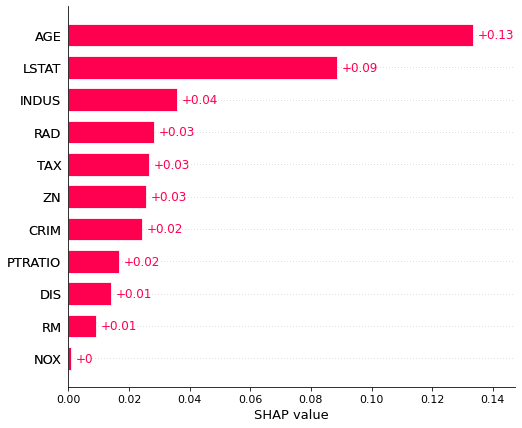

In [9]:
plot_feature_importance_bar(node.diff_feature_importances, feature_order=node.diff_feature_order)
plt.savefig('figures/boston3-diff-feat-imp.pdf', bbox_inches='tight', pad_inches=0)

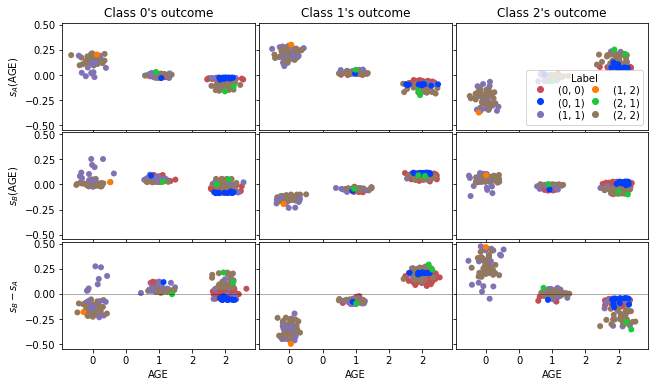

In [10]:
node.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[0]], show_legend=False)
ax = plt.gca().figure.axes[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston3-indiv-depplots-age.pdf', bbox_inches='tight', pad_inches=0)

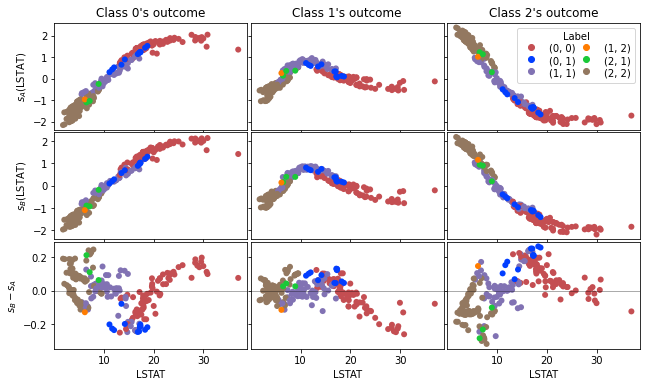

In [11]:
nrows, ncols = 3, 3
axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3.5, nrows*2), sharex='all', sharey='row', squeeze=False, constrained_layout=True)[1]
node.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[1]], show_legend=False, axs=axs)
ax = plt.gca().figure.axes[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston3-indiv-depplots-lstat.pdf', bbox_inches='tight', pad_inches=0)

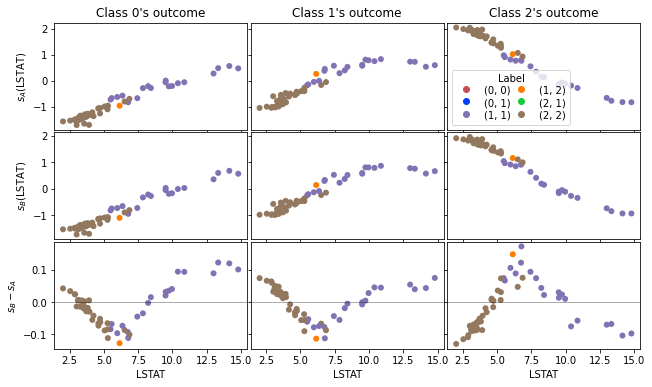

In [12]:
part = node.filter('AGE == 0')
nrows, ncols = 3, 3
axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3.5, nrows*2), sharex='all', sharey='row', squeeze=False, constrained_layout=True)[1]
part.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[1]], show_legend=False, axs=axs)
ax = plt.gca().figure.axes[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)

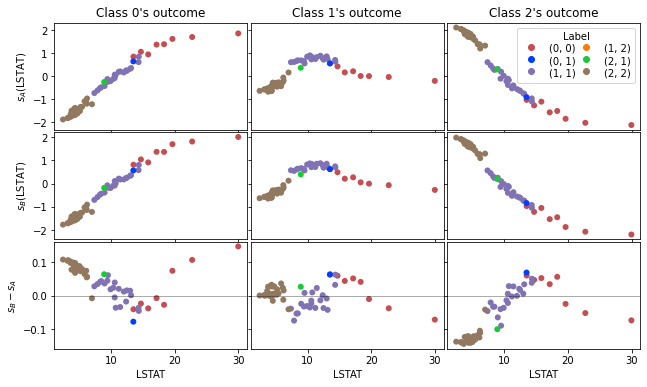

In [13]:
part = node.filter('AGE == 1')
nrows, ncols = 3, 3
axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3.5, nrows*2), sharex='all', sharey='row', squeeze=False, constrained_layout=True)[1]
part.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[1]], show_legend=False, axs=axs)
ax = plt.gca().figure.axes[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)

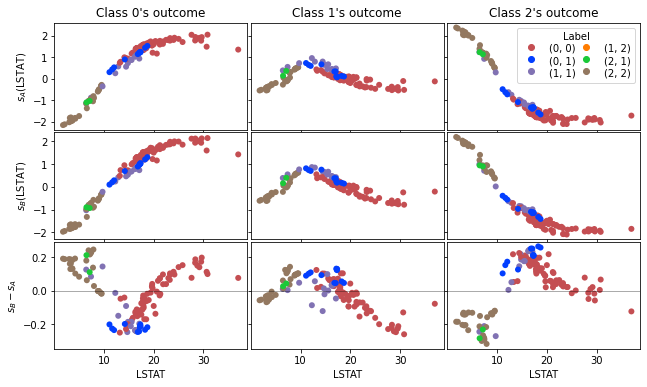

In [14]:
part = node.filter('AGE == 2')
nrows, ncols = 3, 3
axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3.5, nrows*2), sharex='all', sharey='row', squeeze=False, constrained_layout=True)[1]
part.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[1]], show_legend=False, axs=axs)
ax = plt.gca().figure.axes[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)

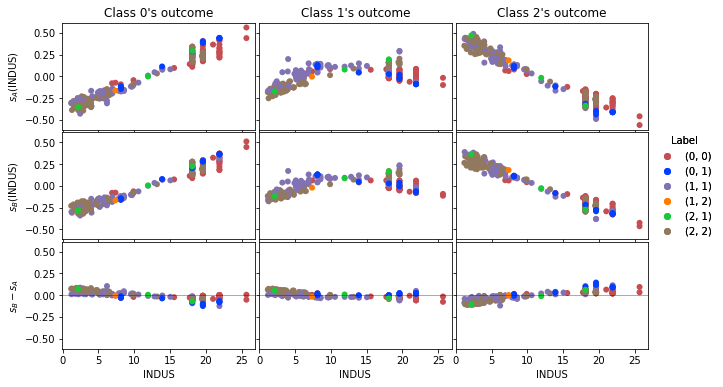

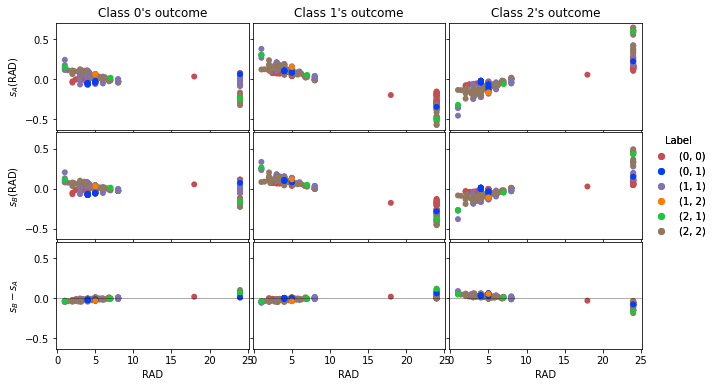

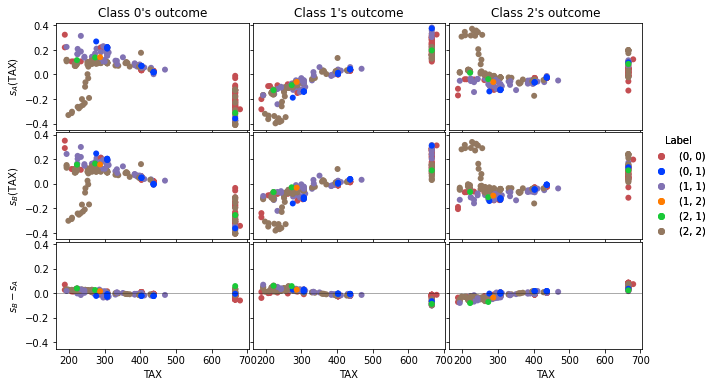

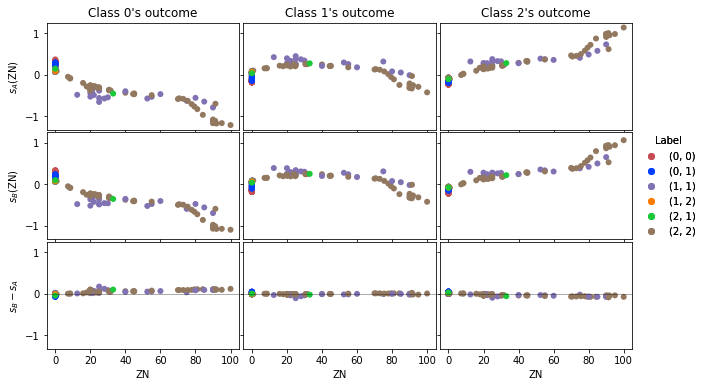

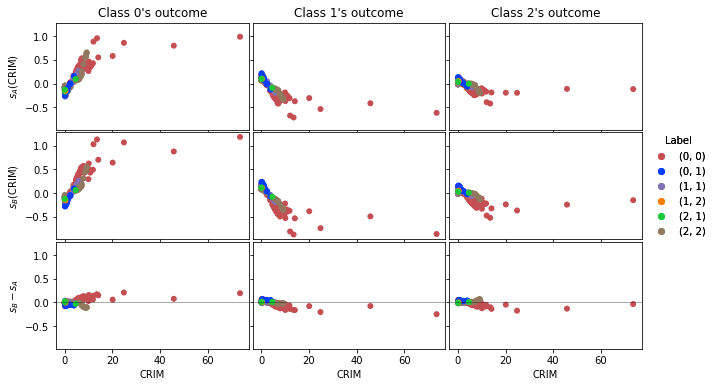

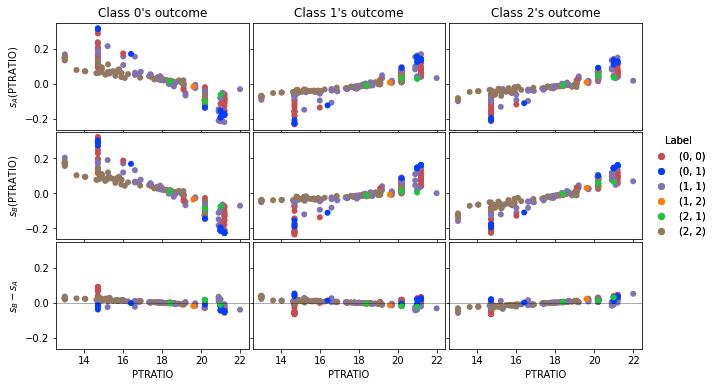

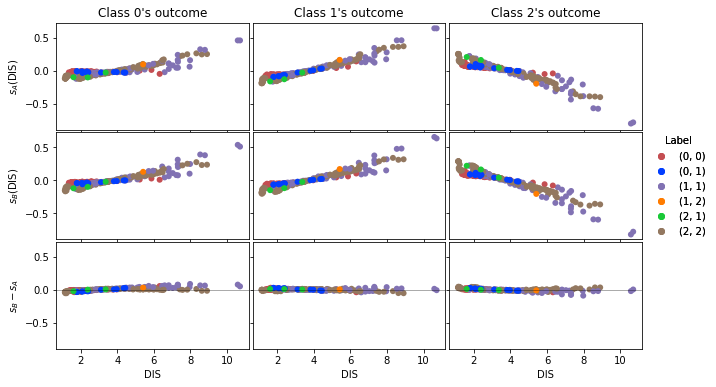

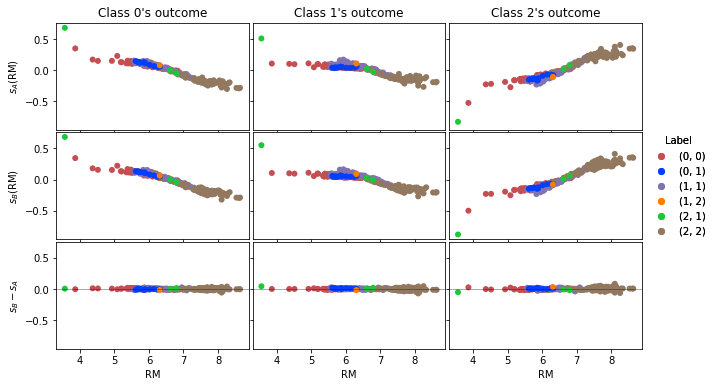

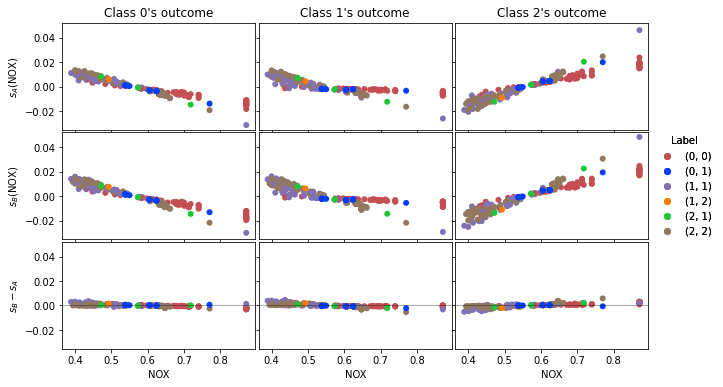

In [15]:
node.plot_indiv_feature_dependence(*feature_names[node.diff_feature_order[2:]])

In [16]:
from clustering import plot_dependence_curves_for_feature

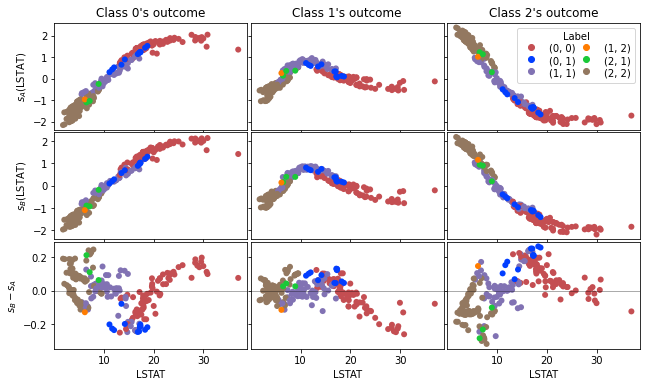

In [17]:
nrows, ncols = 3, 3
axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3.5, nrows*2), sharex='all', sharey='row', squeeze=False, constrained_layout=True)[1]
node.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[1]], show_legend=False, axs=axs)
ax = plt.gca().figure.axes[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston3-indiv-depplots-lstat.pdf', bbox_inches='tight', pad_inches=0)

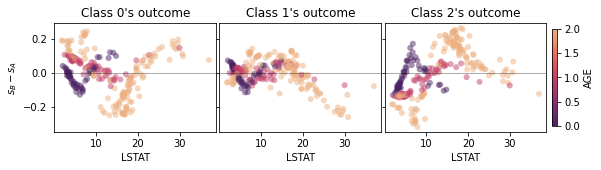

In [18]:
plot_dependence_curves_for_feature(node, 'LSTAT', comparer.base_classes, kind='indiv-diff', color='AGE', alpha=0.5)
plt.savefig('figures/boston3-indiv-depplots-lstat-age.pdf', bbox_inches='tight', pad_inches=0)

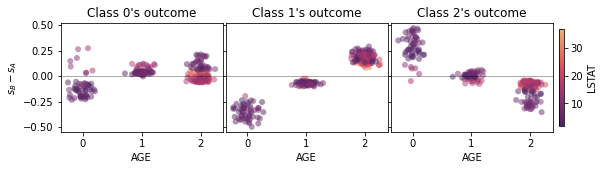

In [19]:
plot_dependence_curves_for_feature(node, 'AGE', comparer.base_classes, kind='indiv-diff', color='LSTAT', alpha=0.5)
plt.savefig('figures/boston3-indiv-depplots-age-lstat.pdf', bbox_inches='tight', pad_inches=0)

# Difference Classifier Explanations

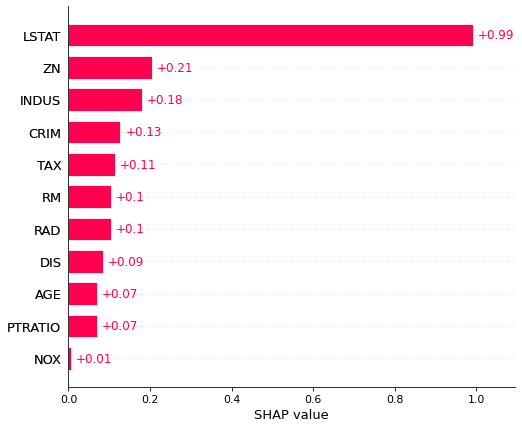

In [20]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

## $(0,1)$

In [21]:
node.focus_class = '(0, 1)'
node.class_counts, node.distance
classes = ['(0, 0)', '(0, 1)', '(1, 1)']

In [22]:
focus = node.descend()
focus

L

In [23]:
print(focus.rule_from_counterfactuals()[0])

10.24 < LSTAT <= 19.16 and ZN <= 5 and CRIM <= 6.1 and AGE > 0


In [24]:
focus.data.loc[focus.highlight, 'AGE'].value_counts()

2.0    12
1.0     1
Name: AGE, dtype: int64

In [25]:
focus.data['LSTAT'].describe()

count    124.000000
mean      17.879507
std        5.198659
min        9.740000
25%       14.412500
50%       17.083348
75%       19.825479
max       36.980000
Name: LSTAT, dtype: float64

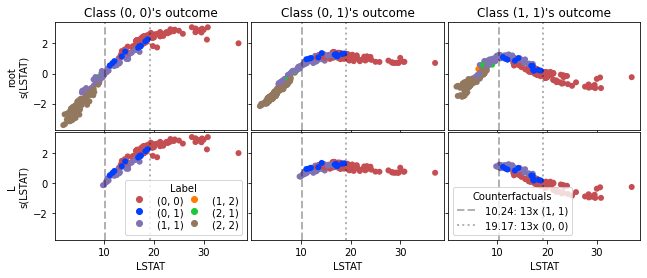

In [26]:
node.plot_feature_dependence('LSTAT', focus=focus, classes=classes, show_legend=False)
fig = plt.gca().figure
ax = fig.axes[3]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)

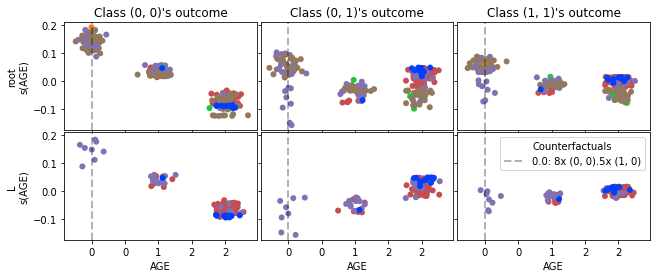

In [27]:
node.plot_feature_dependence('AGE', focus=focus, classes=classes, show_legend=False)

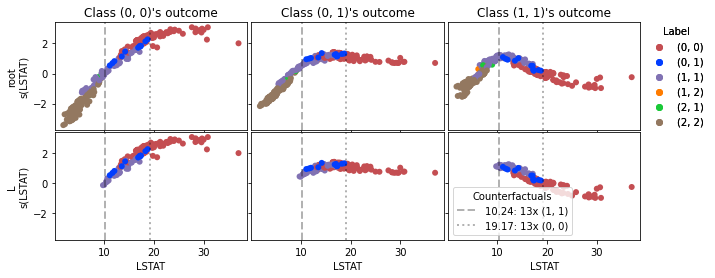

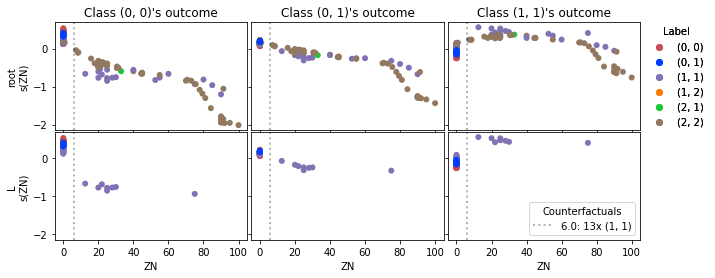

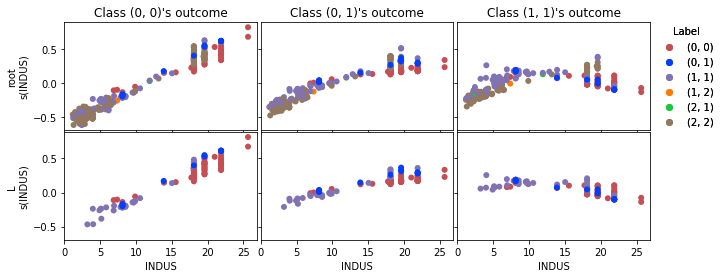

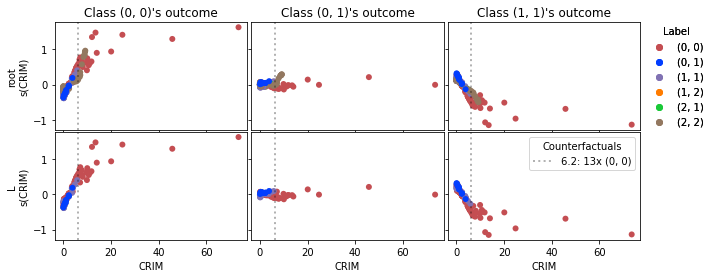

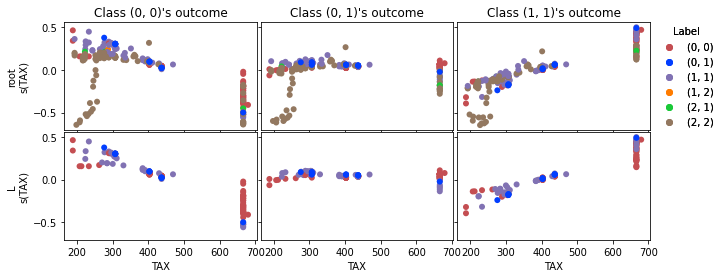

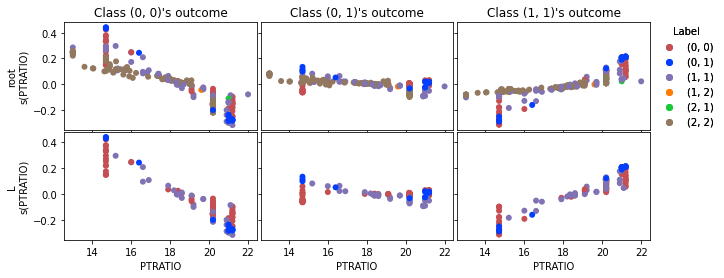

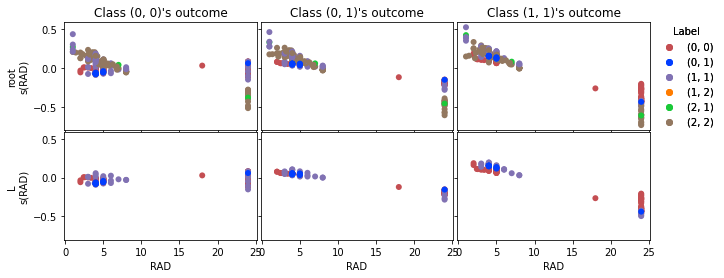

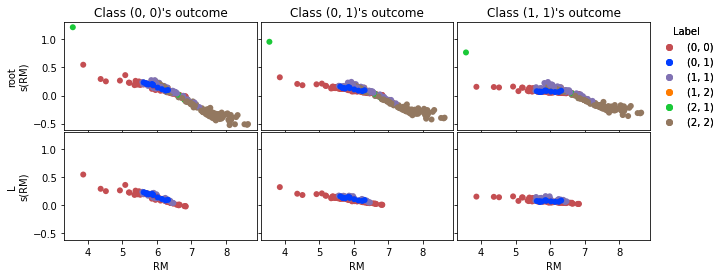

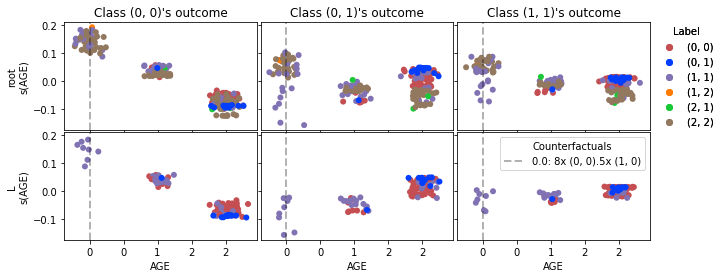

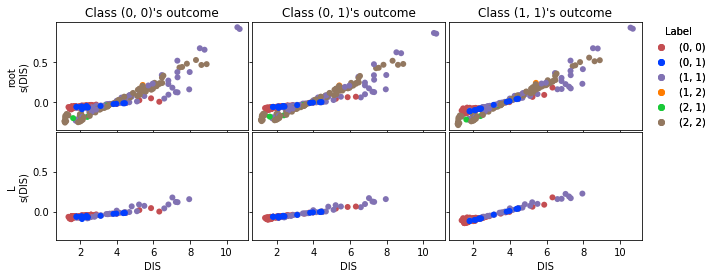

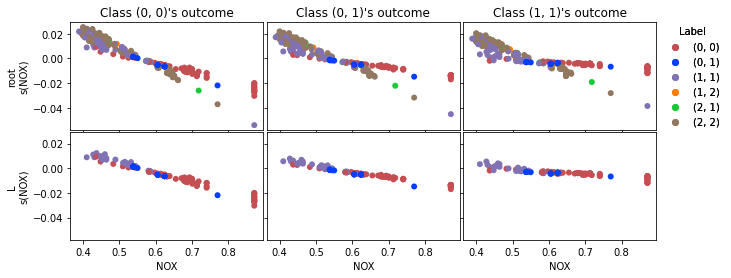

In [28]:
node.plot_feature_dependence(focus=focus, classes=classes)

## (1,2)

In [29]:
node.focus_class = '(1, 2)'
node.class_counts, node.distance
classes = ['(1, 1)', '(1, 2)', '(2, 2)']

In [30]:
focus = node.descend().get_parent(2)
focus, focus.class_counts, focus.distance

(RRLLR,
 (1, 1)    7
 (1, 2)    1
 dtype: int64,
 5.0827266965834035)

In [31]:
print(focus.rule_from_counterfactuals()[0])

4.51 < LSTAT <= 6.27 and 4.27 < RAD <= 12.72 and 1.90 < DIS <= 5.65 and CRIM <= 14.6 and INDUS <= 8.14 and AGE <= 0 and 6.20 < RM <= 7.74 and ZN <= 89 and PTRATIO > 17.34


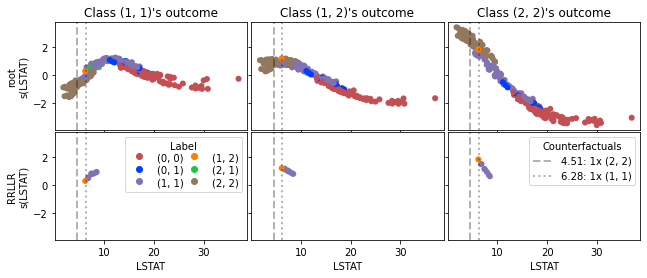

In [32]:
node.plot_feature_dependence('LSTAT', focus=focus, classes=classes, show_legend=False)
fig = plt.gca().figure
ax = fig.axes[3]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston3-depplots-12-lstat.pdf', bbox_inches='tight', pad_inches=0)

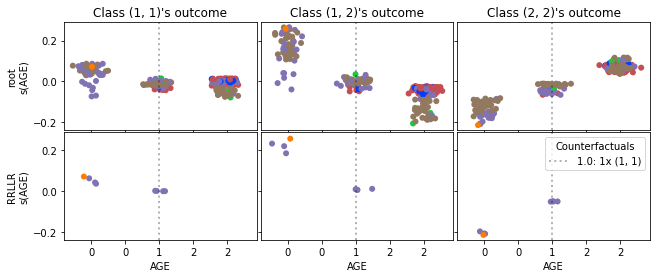

In [33]:
node.plot_feature_dependence('AGE', focus=focus, classes=classes, show_legend=False)
plt.savefig('figures/boston3-depplots-12-age.pdf', bbox_inches='tight', pad_inches=0)

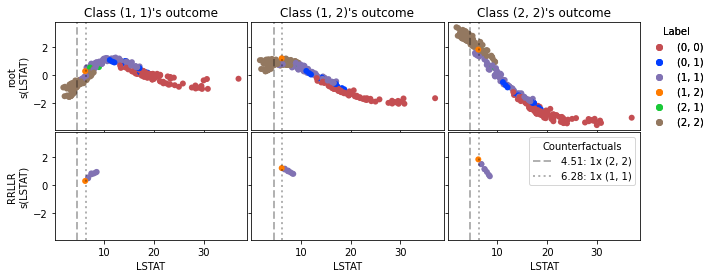

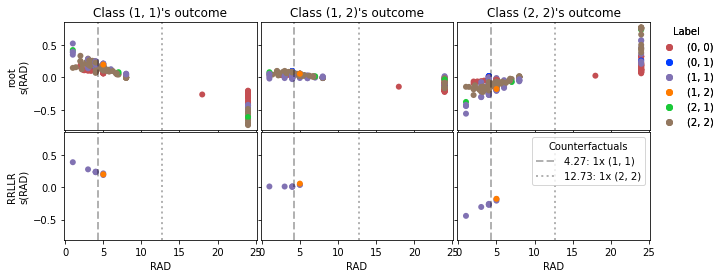

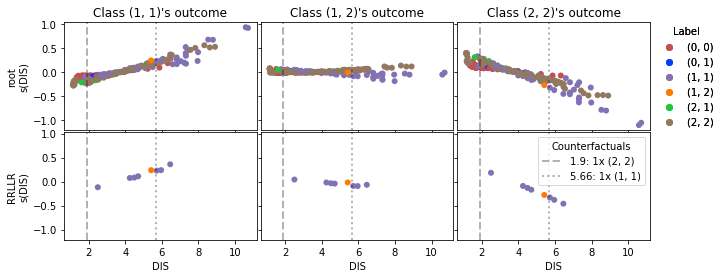

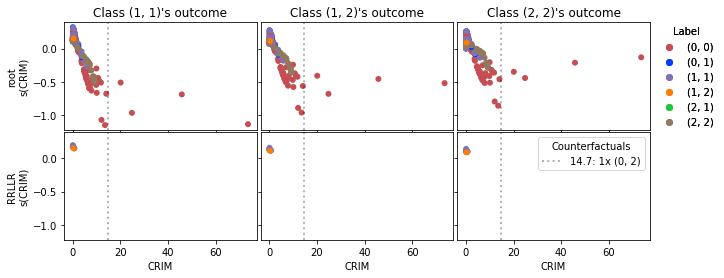

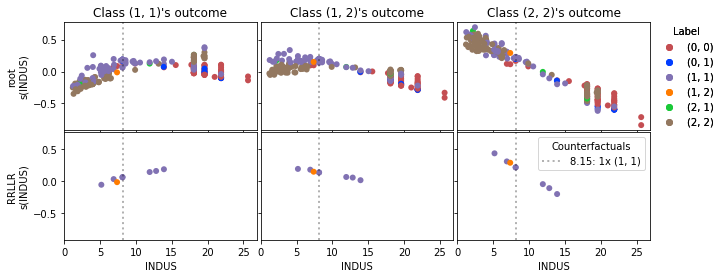

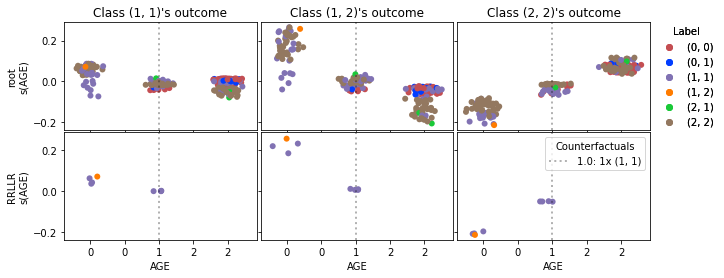

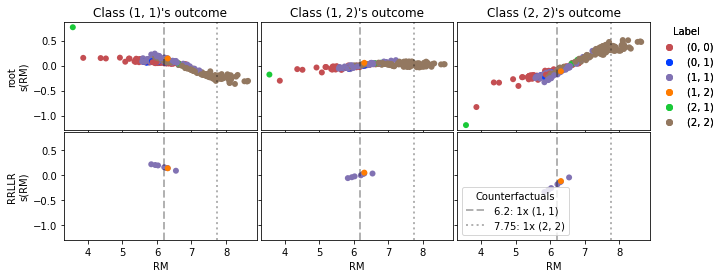

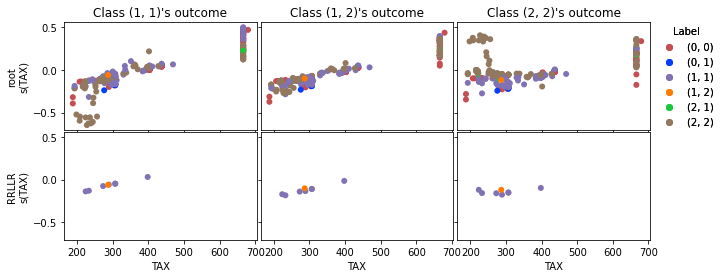

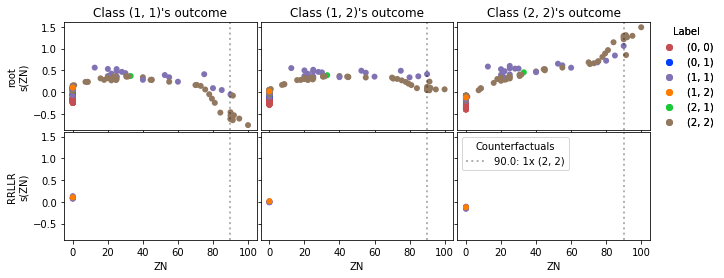

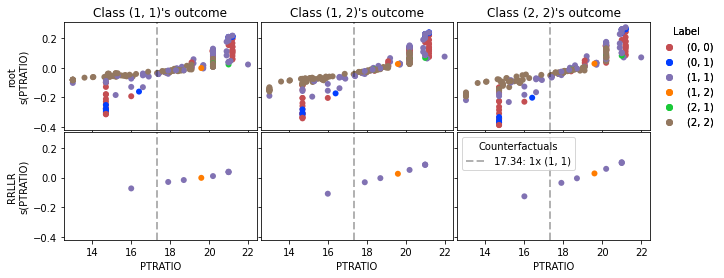

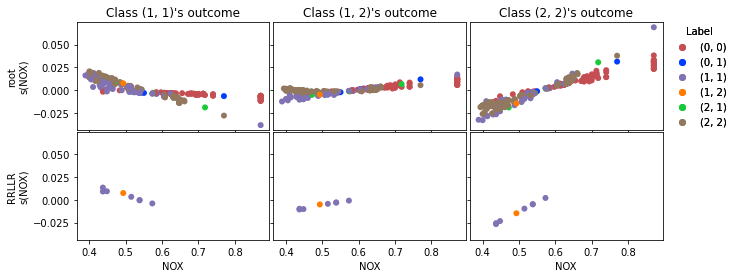

In [34]:
node.plot_feature_dependence(focus=focus, classes=classes)

## (2,1)

In [35]:
node.focus_class = '(2, 1)'
node.class_counts, node.distance
classes = ['(1, 1)', '(2, 1)', '(2, 2)']

In [36]:
focus = node.descend()
focus, focus.class_counts, focus.distance

(RR,
 (2, 2)    32
 (1, 1)    23
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 31.9493959231292)

In [37]:
print(focus.rule_from_counterfactuals()[0])

5.97 < LSTAT <= 9.05 and INDUS <= 19.61 and ZN <= 81 and DIS <= 4.17 and CRIM <= 12.8 and AGE > 0 and RM <= 7.21


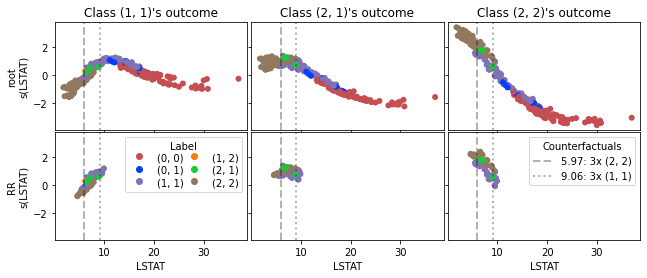

In [38]:
node.plot_feature_dependence('LSTAT', focus=focus, classes=classes, show_legend=False)
fig = plt.gca().figure
ax = fig.axes[3]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston3-depplots-21-lstat.pdf', bbox_inches='tight', pad_inches=0)

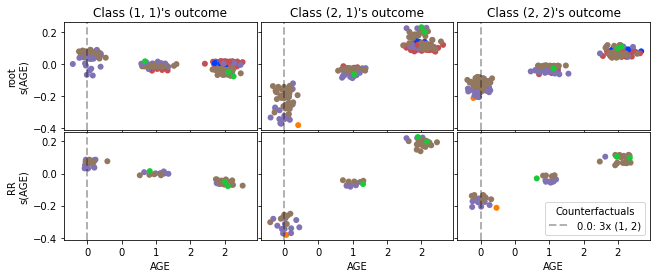

In [39]:
node.plot_feature_dependence('AGE', focus=focus, classes=classes, show_legend=False)
plt.savefig('figures/boston3-depplots-21-age.pdf', bbox_inches='tight', pad_inches=0)

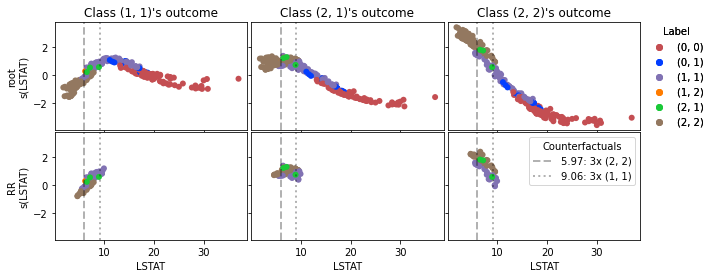

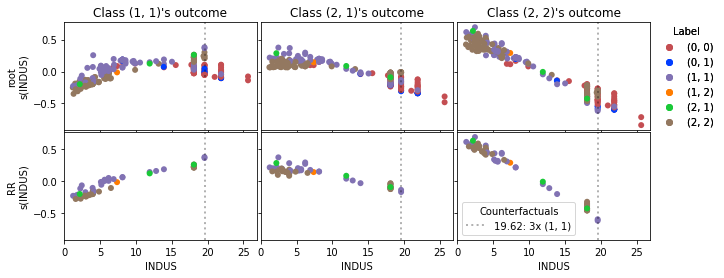

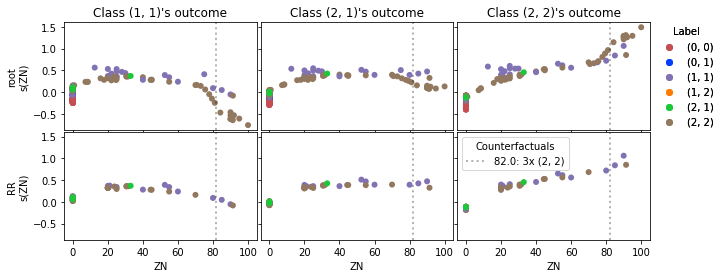

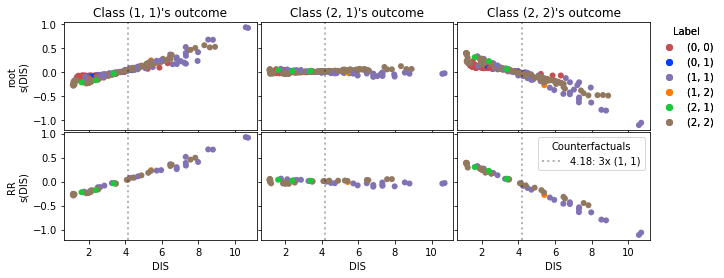

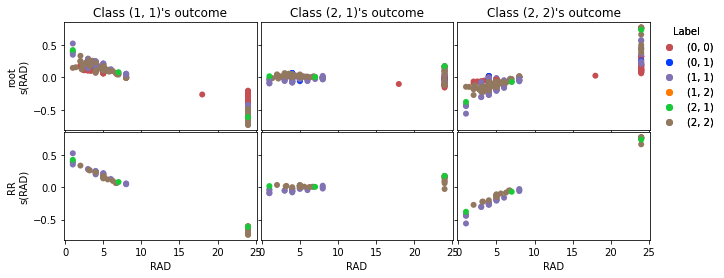

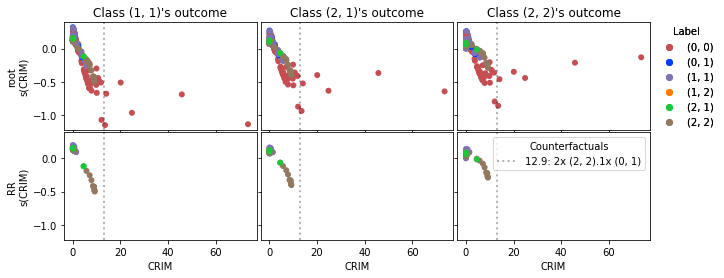

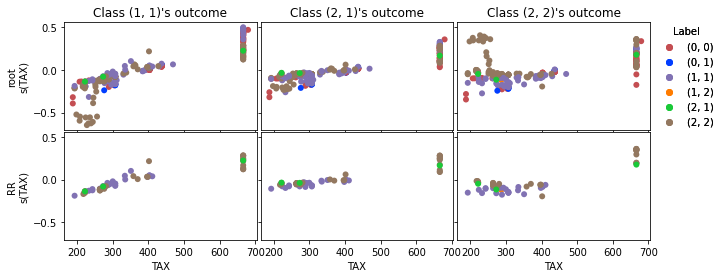

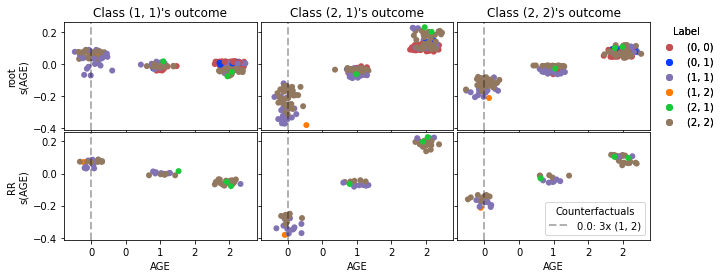

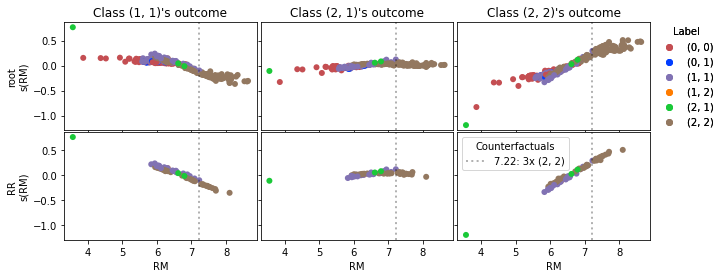

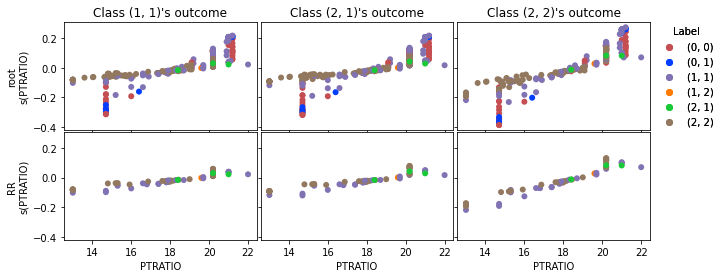

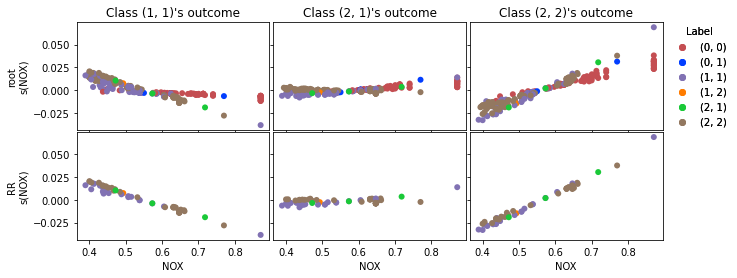

In [40]:
node.plot_feature_dependence(focus=focus, classes=classes)

# Additional Plots

In [52]:
from clustering import plot_dependence_curves_for_nodes, _DEFAULT_FIGSIZE

In [143]:
node = node.root
node.focus_class = '(0, 1)'

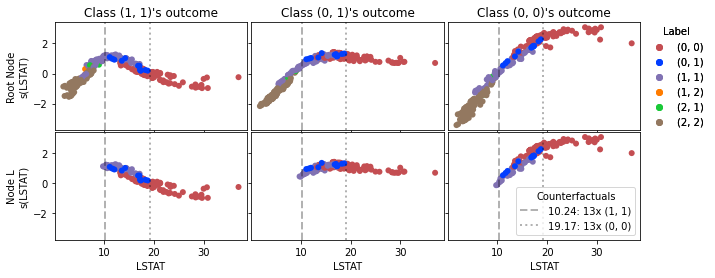

In [144]:
node.plot_feature_dependence('LSTAT', classes=['(1, 1)', '(0, 1)', '(0, 0)'], focus=node.descend())

In [141]:
node = node.descend()
node

L

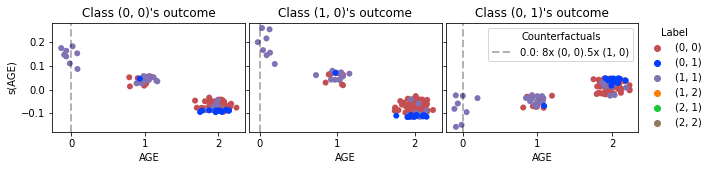

In [139]:
node.plot_feature_dependence('AGE', classes=['(0, 0)', '(1, 0)', '(0, 1)'])
plt.savefig('figures/boston-diffclf-depplots-01-age.pdf', bbox_inches='tight', pad_inches=0)

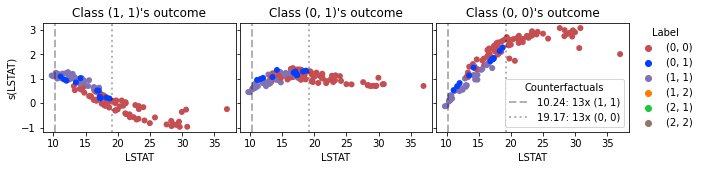

In [140]:
node.plot_feature_dependence('LSTAT', classes=['(1, 1)', '(0, 1)', '(0, 0)'])
plt.savefig('figures/boston-diffclf-depplots-01-lstat.pdf', bbox_inches='tight', pad_inches=0)

In [142]:
node = node.root
node.focus_class = '(1, 2)'

In [123]:
node = node.root.get('RR')

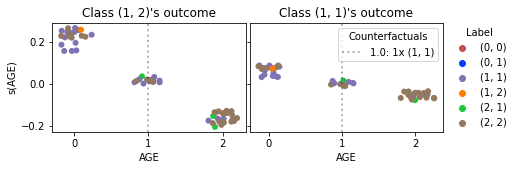

In [124]:
node.plot_feature_dependence('AGE', classes=['(1, 2)', '(1, 1)'])

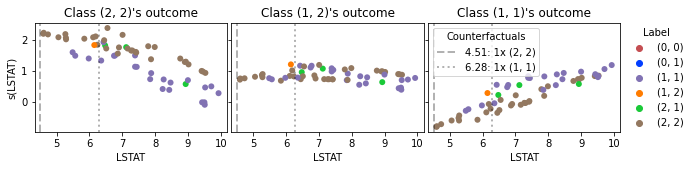

In [126]:
node.plot_feature_dependence('LSTAT', classes=['(2, 2)', '(1, 2)', '(1, 1)'])

In [127]:
node.focus_class = '(2, 1)'

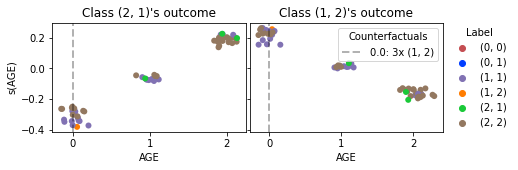

In [128]:
node.plot_feature_dependence('AGE', classes=['(1, 2)', '(2, 1)'])

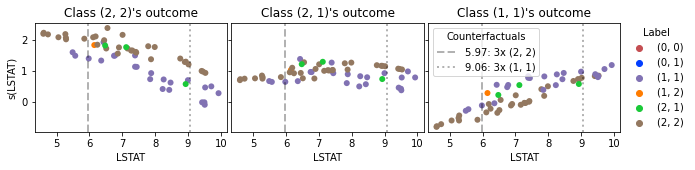

In [131]:
node.plot_feature_dependence('LSTAT', classes=['(2, 2)', '(2, 1)', '(1, 1)'])